In [9]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import pingouin as pg
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *
palette_tab10 = sns.color_palette("tab10", 10)

#### Load data

In [42]:
# Load FFR peaks
accuracies = pd.read_csv('accuracies.csv')
accuracies = accuracies.rename(columns = {"sub_num": "subject", "accuracy": "accuracy_score", "accuracy_group": "accuracy"})
accuracies

# Load accuracy scores
ffr_peaks = pd.read_csv('ffr_peaks.csv')

# Add accuracies into FFR df
ffr_peaks = ffr_peaks.merge(accuracies, left_on = ["subject"], right_on = ["subject"])

# Drop subjects with fewer than 80% EEG trials
BADS = [2, 3, 4, 5, 6, 7, 8, 9, 33, 37]
for bad in BADS:
    ffr_peaks = ffr_peaks[ffr_peaks['subject'] != bad]
np.unique(ffr_peaks['subject'])

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

#### ANOVA by target 

                  Anova
            F Value Num DF  Den DF  Pr > F
------------------------------------------
tone        12.3764 2.0000  58.0000 0.0000
target       1.1146 2.0000  58.0000 0.3350
tone:target  0.5214 4.0000 116.0000 0.7202



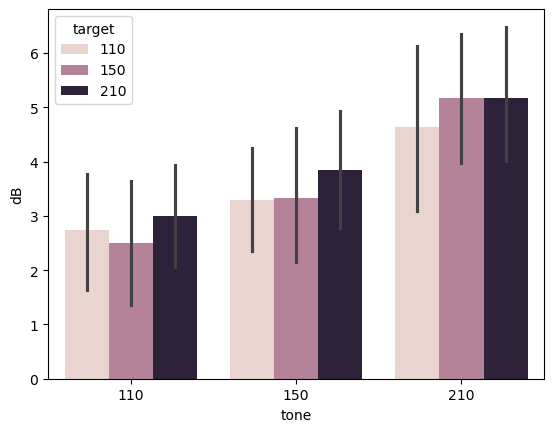

In [43]:
ffr_target = ffr_peaks.groupby(['subject', 'tone', 'target'], as_index=False)['dB'].mean()
sns.barplot(ffr_target, x="tone", y="dB", hue="target")
aov = AnovaRM(
    data = ffr_target, 
    depvar = 'dB',
    subject = 'subject', 
    within = ['tone', 'target']
)
res = aov.fit()
print(res)

#### ANOVA by target and predictability

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
tone                    12.3764 2.0000  58.0000 0.0000
target                   1.1146 2.0000  58.0000 0.3350
predictable              1.0227 1.0000  29.0000 0.3202
tone:target              0.5214 4.0000 116.0000 0.7202
tone:predictable         0.3924 2.0000  58.0000 0.6772
target:predictable       0.6553 2.0000  58.0000 0.5231
tone:target:predictable  0.4930 4.0000 116.0000 0.7409

                    Anova
                 F Value Num DF  Den DF Pr > F
----------------------------------------------
tone             12.3764 2.0000 58.0000 0.0000
predictable       1.0227 1.0000 29.0000 0.3202
tone:predictable  0.3924 2.0000 58.0000 0.6772



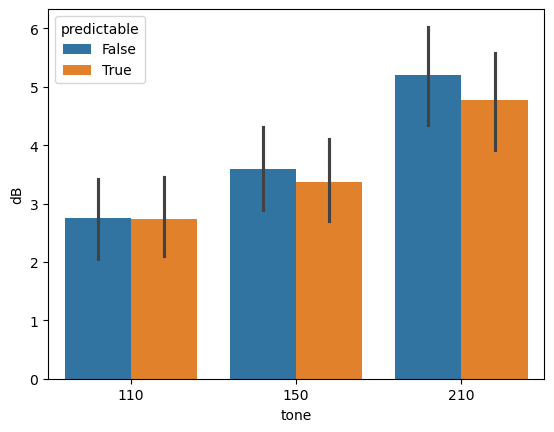

In [46]:
ffr_predictability = ffr_peaks.groupby(['subject', 'tone', 'target', 'predictable'], as_index=False)['dB'].mean()
sns.barplot(ffr_predictability, x="tone", y="dB", hue="predictable")
aov = AnovaRM(
    data = ffr_predictability, 
    depvar = 'dB',
    subject = 'subject', 
    within = ['tone', 'target', 'predictable']
)
res = aov.fit()
print(res)

ffr_predictability = ffr_peaks.groupby(['subject', 'tone', 'predictable'], as_index=False)['dB'].mean()
aov = AnovaRM(
    data = ffr_predictability, 
    depvar = 'dB',
    subject = 'subject', 
    within = ['tone', 'predictable']
)
res = aov.fit()
print(res)

#### ANOVA by accuracy


ANOVA SUMMARY

Source           SS    DF1    DF2      MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
accuracy     57.871      1     28  57.871   2.977    0.095      nan      0.096  nan           nan        nan        nan
tone         78.766      2     56  39.383  13.356    0.000        0.000  0.323    0.805         0.000      0.757      0.020
Interaction  19.436      2     56   9.718   3.296    0.044      nan      0.105  nan           nan        nan        nan



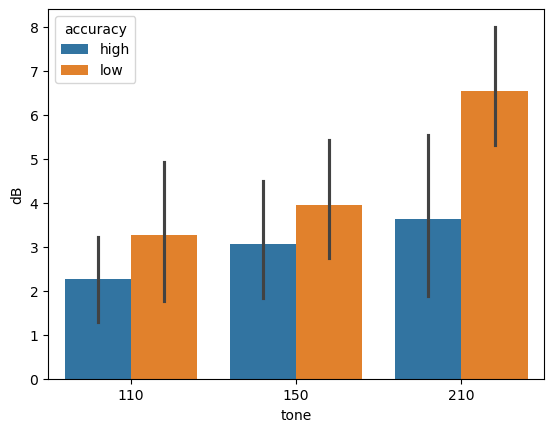

In [45]:
ffr_accuracy = ffr_peaks.groupby(['subject', 'tone', 'accuracy'], as_index=False)['dB'].mean()
sns.barplot(ffr_accuracy, x="tone", y="dB", hue="accuracy")
aov = ffr_accuracy.mixed_anova(dv='dB', within='tone', between='accuracy', subject='subject')
pg.print_table(aov)